## 5.1 Evaluating generative text models

In [60]:
import torch

In [61]:
import torch.nn as nn

In [62]:
import tiktoken

In [63]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [64]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
               torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x ** 3)
                                        )
                         )

In [65]:
class GELUNew(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer("_a", torch.tensor(0.7978845608))  # sqrt(2/pi)
        self.register_buffer("_b", torch.tensor(0.044715))

    def forward(self, x):
        a = self._a.to(dtype=x.dtype)  # 与输入匹配 dtype
        b = self._b.to(dtype=x.dtype)
        return 0.5 * x * (1.0 + torch.tanh(a * (x + b * x * x * x)))


In [66]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
#         self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), 
#                                    GELU(),
#                                    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), 
                                   GELUNew(),
                                   nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

    def forward(self, x):
        return self.layers(x)

In [67]:
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads ==0), "d_out must be divisible by num_heads"  
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # 多头相当于将单头等比例拆分，计算后再合并
        self.W_q = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = torch.nn.Linear(d_out, d_out)  # 合并后使信息交融
        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)
        
        # 进行reshape，分成多头
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights_dropout = self.dropout(attn_weights)
        
        context_vec = (attn_weights_dropout @ values).transpose(1, 2)  # 变回原顺序以便reshape回原来形状
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        
        return context_vec

In [68]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(  # 注意力模块
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        
        self.ff = FeedForward(cfg)  # 前向传播
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        return x

In [69]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head =  nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, 
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [12]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")

In [14]:
# 将文本转化为toekn id
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encode_tensor = torch.tensor(encoded).unsqueeze(0) # 增加1维
    
    return encode_tensor

In [15]:
# 将token id转化为文本
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    flat_ls = flat.tolist()
    ids_to_text = tokenizer.decode(flat_ls)
    
    return ids_to_text
    

In [16]:
start_context = "Every effort moves you"
token_ids = generate_text_simple(model=model, idx=text_to_token_ids(start_context, tokenizer), 
                                 max_new_tokens=10, context_size=GPT_CONFIG_124M['context_length'])

In [17]:
gen_text = token_ids_to_text(token_ids, tokenizer)
print("result:", gen_text)

result: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [18]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

In [19]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [20]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [21]:
# target
token_ids_to_text(targets[0], tokenizer)

' effort moves you'

In [22]:
# output
token_ids_to_text(token_ids[0].flatten(), tokenizer)

' Armed heNetflix'

In [23]:
# 取出正确位置上的概率（输入只有3个token，所以中间是[0, 1, 2]）
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [24]:
# 取对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [25]:
# 取均值
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [26]:
# 取相反数
negative_avg_log_probas = avg_log_probas * -1
print(negative_avg_log_probas)

tensor(10.7940)


以上手动实现了交叉熵损失函数的结果，优化的目标就是使得预测结果对应target位置上的概率最大，即接近1，此时log1=0，所以当交叉熵结果接近0时，预测值与真实值一致

**手工实现交叉熵（cross-entropy）**。核心公式只有一条：

$$
\text{CE} = -\frac{1}{N}\sum_{i=1}^{N}\log p_\theta\big(y_i\mid x_i\big)
$$

也就是：对每个位置 $i$，“正确类别 $y_i$” 的**预测概率**取对数，再取负号并求平均。

1. `probas = softmax(logits)`
   得到每个位置对所有token的预测概率 $p_\theta(\cdot\mid x_i)$。

2. `probas[text_idx, [0,1,2], targets[text_idx]]`
   这一步相当于用索引/`gather`把“每个位置上**正确token id**的概率”取出来，也就是
   $[p_\theta(y_0\mid x_0),\ p_\theta(y_1\mid x_1),\ p_\theta(y_2\mid x_2)]$。

3. `torch.cat((target_probas_1, target_probas_2))`
   只是把**两条样本序列**（Text 1、Text 2）在同一维度上拼成一个更长的一维向量，方便**一次性**对所有位置求一个整体平均损失。等价地，你也可以分别算两段的loss再求平均；`cat`不改变数值含义，只是做了**拼接以便聚合**。

4. `torch.log(...)`
   对这些“正确类别的概率”取对数，得到 $\log p_\theta(y_i\mid x_i)$。接下来取负号、再求平均，就是交叉熵/负对数似然（NLL）损失。

尝试使用pytorch内置的交叉熵函数

In [27]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [28]:
logits_flatten = logits.flatten(0, 1)
targets_flatten = targets.flatten()
print(logits_flatten.shape)
print(targets_flatten.shape)

torch.Size([6, 50257])
torch.Size([6])


In [29]:
loss = nn.functional.cross_entropy(logits_flatten, targets_flatten)
print(loss)

tensor(10.7940)


使用Perplexity判断一致性

In [30]:
perplexity = torch.exp(loss)

In [31]:
perplexity

tensor(48725.8203)

## 理解困惑度
### 1. 从交叉熵出发

对一个序列，交叉熵（平均负对数似然）是

$$
\text{loss} = - \frac{1}{N} \sum_{i=1}^N \log p_\theta(y_i \mid x_i)
$$

其中 $p_\theta(y_i \mid x_i)$ 是模型在第 $i$ 个位置对正确 token 的预测概率。

---

### 2. 困惑度定义

$$
\text{PPL} = \exp(\text{loss})
$$

代进去：

$$
\text{PPL} = \exp\!\left(- \frac{1}{N} \sum_{i=1}^N \log p_\theta(y_i \mid x_i)\right)
$$

这其实就是**几何平均倒数**：

$$
\text{PPL} = \left(\prod_{i=1}^N \frac{1}{p_\theta(y_i \mid x_i)} \right)^{1/N}
$$

---

### 3. 理解“等效候选数”

如果模型在每个位置都是完全均匀分布，概率是：

$$
p_\theta(y_i \mid x_i) = \frac{1}{M}
$$

其中 $M$ 是均匀候选数。

那么：

$$
\text{loss} = - \log \frac{1}{M} = \log M
$$

再取指数：

$$
\text{PPL} = \exp(\log M) = M
$$

👉 这说明 **困惑度正好等于均匀分布下的候选 token 数量**。

---

### 4. 推广到非均匀情况

当模型分布不完全均匀时，PPL 就是那个“等效均匀分布的大小”。
换句话说，它等价于：
**如果有一个均匀分布能产生同样的不确定性，它的候选大小是多少？**

---

更精确地说：

* **交叉熵（loss）** 度量了模型预测分布和真实分布之间的不确定性。
* **困惑度（PPL） = exp(loss)** 就是把这个不确定性重新“翻译”成 **一个等价的均匀分布规模**。

换句话说：

* 在非均匀的实际预测里，不同 token 概率差异很大。
* 但 PPL 会问：“如果有一个均匀分布，它的不确定性（熵）等价于模型当前的分布，那这个均匀分布有多少个候选 token？”

于是你就能把复杂的概率分布，转化为一个直观的数值 —— **等效候选数量**。





### Calculating the training and validation set losses

In [32]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [33]:
# cuda是否可用
print(torch.cuda.is_available())  

True


In [34]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [35]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [36]:
# 划分训练集和测试集
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [37]:
from torch.utils.data import Dataset, DataLoader

In [38]:
# 将文本转化为token_id并以tensor形式存储
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)
        
        for i in range(0, len(token_ids) - max_length, stride):  # 建立对应的输入和输出toekn_id tensor
            input_chunk = token_ids[i: i+ max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    def __len__(self):
        return len(self.input_ids)  # 判断长度
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  # 返回输入和目标tensor中某一行

In [39]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
                            dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last, 
                            num_workers=num_workers 
    )
    return dataloader

In [40]:
torch.manual_seed(123)

In [41]:
train_loader = create_dataloader_v1(
 train_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)

val_loader = create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

In [42]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [43]:
# 计算一个batch的loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) 
    target_batch = target_batch.to(device) 
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
           logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [44]:
# 计算多个batch的损失
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    
    # 得到batch数量
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) 
    else:
        num_batches = min(num_batches, len(data_loader)) 
        
    # 累加每个batch的loss    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
            
        else:
            break
    
    # 返回每个batch平均loss
    return total_loss / num_batches

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device) 
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.981104850769043


## 5.2 Training an LLM

In [46]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, 
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # eval_freq表示多少步(step)后评估(evaluate)一次 eval_iter表示用多少个batch计算一次损失
    train_losses, val_losses, track_tokens_seen = [], [], []  # track_tokens_seen在每次要评估的时候加入tokens_seen
    tokens_seen, global_step = 0, -1  # tokens_seen记录每次循环后看到的tokens数
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 每次要重置梯度，防止梯度累计
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            loss.backward()  # 在此处反向传播更新梯度
            
            optimizer.step()  # 更新权重w
            
            tokens_seen += input_batch.numel()
            
            global_step += 1
            
            if global_step % eval_freq == 0:  # 当步数和预设相同
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  # 一个列表，记录了每eval_freq步后的损失
                val_losses.append(val_loss)
                
                track_tokens_seen.append(tokens_seen)
                
                print(f"Ep {epoch + 1} (Step {global_step:06d}):"
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}")
                
        generate_and_print_sample(model, tokenizer, device, start_context)  # 生成一些文本看效果
                
    return train_losses, val_losses, track_tokens_seen
    

In [47]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # 改为评价模式，消除dropout的影响
    with torch.no_grad():  # 禁用梯度计算，节省算力
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    model.train()  # 恢复训练状态
    return train_loss, val_loss
    

In [48]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()  # 推理状态同样关闭dropout
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    print(decoded_text.replace("\n", " "))
    
    model.train()  # 恢复训练状态

In [59]:
# 训练模型
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(model, train_loader, val_loader, optimizer, device,
                                                         num_epochs=num_epochs, eval_freq=5, eval_iter=5,
                                                         start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000):Train loss 9.820,Val loss 9.786
Ep 1 (Step 000005):Train loss 7.921,Val loss 8.192
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010):Train loss 6.585,Val loss 6.740
Ep 2 (Step 000015):Train loss 5.986,Val loss 5.995
Every effort moves you, the, and, the, the, the, the. ", the, the,,, the, and, the,, the,, the, and, the, the,, the, and,,,, the,
Ep 3 (Step 000020):Train loss 15.840,Val loss 15.627
Ep 3 (Step 000025):Train loss 5.589,Val loss 5.469
Every effort moves you. Gis. Gis. Gis. Gis. G. I had to----I--I, and--and, and I had. I had to the his--. Gis. Gisburn, and I had.
Ep 4 (Step 000030):Train loss 5.357,Val loss 5.251
Ep 4 (Step 000035):Train loss 4.778,Val loss 4.862
Every effort moves you.                                                 
Ep 5 (Step 000040):Train loss 4.278,Val loss 4.227
Every effort moves you know the picture to have the picture--I was his pictures a little of his.                                 
Ep

In [62]:
print(len(train_losses), train_losses)

18 [9.81980628967285, 7.921169471740723, 6.585442543029785, 5.985573863983154, 15.840124130249023, 5.589002513885498, 5.356519889831543, 4.777993202209473, 4.278285169601441, 3.6672969818115235, 3.2641485691070558, 2.824545478820801, 2.1874632835388184, 1.815918517112732, 1.429431104660034, 1.1708296537399292, 0.9548979043960572, 0.6591730356216431]


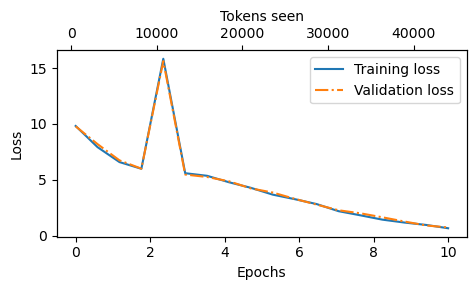

In [60]:
# 可视化训练结果
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, token_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny() 
    ax2.plot(token_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness

In [63]:
# 回到cpu
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [64]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer),
 max_new_tokens=25,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 Temperature scaling

在softmax前令logits / temperature, 如果temperature=1, 不变，temperature<1， 放大差距，结果更稳定，temperature>1，缩小差距，结果更灵活 

In [65]:
vocab = { 
 "closer": 0,
 "every": 1, 
 "effort": 2, 
 "forward": 3,
 "inches": 4,
 "moves": 5, 
 "pizza": 6,
 "toward": 7,
 "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

In [66]:
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [67]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [86]:
# multinomial按比例概率选择，结果是logits大的依然被选择，但不会稳定在一个
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [56]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

RuntimeError: prob_dist must be 1 or 2 dim

由于multinomial按比例计算，当使用temperature参数时，可以通过放大活缩小比例来选择灵活性

In [90]:
# 在softmax中加入temperature参数
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

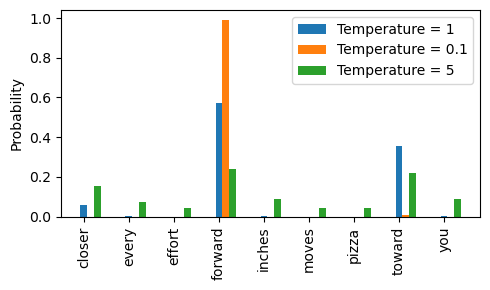

In [91]:
temperatures = [1, 0.1, 5] 
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

### 5.3.2 Top-k sampling

先选择logit最大的k个，再将其余logits设为无穷小，之后再softmax得到比例，这样非topk的prob为0，会在topk个token里选择

In [92]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [93]:
new_logits = torch.where(
     condition=next_token_logits < top_logits[-1], 
     input=torch.tensor(float('-inf')), 
     other=next_token_logits 
    )
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [94]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

In [49]:
# 加入topk和temperature strategy后的生成函数
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):  # eos指 end of sentence，是词表里的特殊符号
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # 选择生成的待选择序列
        
        # 加入top_k
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)  # 选择
            min_val = top_logits[:, -1]
            
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)
        
        # 加入temperature
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        # 最原始的直接选最大logits
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:  # 如果遇到句子结束就停止
            break
            
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [104]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
    )
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen. It was not it was such not to his history


## 5.4 Loading and saving model weights in PyTorch

In [105]:
# 存储训练后的参数
torch.save(model.state_dict(), "model.pth")

In [108]:
# 查看参数大小
import os

file_path = "model.pth"
size_bytes = os.path.getsize(file_path)
size_mb = size_bytes / (1024 * 1024)  # 转换为 MB

print(f"文件大小: {size_mb:.2f} MB")

文件大小: 622.63 MB


In [106]:
# 将存储结果应用在新建立的模型上
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_feat

In [109]:
# 同时存储权重和存储优化器参数，存储优化器参数为了接着训练时使用之前学习的结果
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 }, 
 "model_and_optimizer.pth"
)

In [58]:
# 可以开始继续训练
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading pretrained weights from OpenAI

In [1]:
pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.


In [2]:
# 下载模型权重的下载文件
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x2247ae420d0>)

In [3]:
# 下载gpt2的权重
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

D:\anaconda\anaconda1\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 2.0.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "D:\anaconda\anaconda1\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\anaconda\anaconda1\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\anaconda\anaconda1\lib\site-packages\ipykernel_l

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "D:\anaconda\anaconda1\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\anaconda\anaconda1\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\anaconda\anaconda1\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\anaconda\anaconda1\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "D:\anaconda\anaconda1\lib\site-packages\ipykernel\

AttributeError: _ARRAY_API not found

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [50]:
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

In [51]:
def hf_gpt2_to_textbook_params(model_name: str = "gpt2"):
    """
    将 Hugging Face 的 GPT-2 模型转换为教材 load_weights_into_gpt 所需的 (settings, params) 结构。
    适配以下键名：wte, wpe, g, b, blocks[i].attn.c_attn.{w,b}, blocks[i].attn.c_proj.{w,b},
                 blocks[i].mlp.c_fc.{w,b}, blocks[i].mlp.c_proj.{w,b}, blocks[i].ln_1.{g,b}, ln_2.{g,b}
    """
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForCausalLM.from_pretrained(model_name)
    sd = mdl.state_dict()
    cfg = mdl.config

    settings = {
        "n_vocab": cfg.vocab_size,
        "n_ctx":   cfg.n_positions,
        "n_embd":  cfg.n_embd,
        "n_head":  cfg.n_head,
        "n_layer": cfg.n_layer,
        "activation_function": getattr(cfg, "activation_function", "gelu"),
        "layer_norm_epsilon":  getattr(cfg, "layer_norm_epsilon", 1e-5),
    }

    to_np = lambda t: t.detach().cpu().numpy().astype(np.float32)

    params = {}
    # embeddings
    params["wte"] = to_np(sd["transformer.wte.weight"])  # [vocab, n_embd]
    params["wpe"] = to_np(sd["transformer.wpe.weight"])  # [n_ctx, n_embd]

    # final layer norm -> 顶层 g/b（教材命名）
    params["g"] = to_np(sd["transformer.ln_f.weight"])
    params["b"] = to_np(sd["transformer.ln_f.bias"])

    blocks = []
    for i in range(cfg.n_layer):
        blk = {}

        # ---- Attention ----
        blk.setdefault("attn", {})
        # fused qkv
        blk["attn"].setdefault("c_attn", {})
        W_qkv = to_np(sd[f"transformer.h.{i}.attn.c_attn.weight"])   # [n_embd, 3*n_embd]
        b_qkv = to_np(sd[f"transformer.h.{i}.attn.c_attn.bias"])     # [3*n_embd]
        # 教材稍后会 np.split(..., axis=-1) 并在赋值处 .T，这里保持 fused 形式
        blk["attn"]["c_attn"]["w"] = W_qkv
        blk["attn"]["c_attn"]["b"] = b_qkv

        # out proj
        blk["attn"]["c_proj"] = {
            "w": to_np(sd[f"transformer.h.{i}.attn.c_proj.weight"]),  # [n_embd, n_embd]  教材赋值时会 .T
            "b": to_np(sd[f"transformer.h.{i}.attn.c_proj.bias"]),
        }

        # ---- MLP ----
        blk.setdefault("mlp", {})
        blk["mlp"]["c_fc"] = {
            "w": to_np(sd[f"transformer.h.{i}.mlp.c_fc.weight"]),     # [n_embd, 4*n_embd] 教材赋值时 .T
            "b": to_np(sd[f"transformer.h.{i}.mlp.c_fc.bias"]),
        }
        blk["mlp"]["c_proj"] = {
            "w": to_np(sd[f"transformer.h.{i}.mlp.c_proj.weight"]),   # [4*n_embd, n_embd] 教材赋值时 .T
            "b": to_np(sd[f"transformer.h.{i}.mlp.c_proj.bias"]),
        }

        # ---- LayerNorms ----
        blk["ln_1"] = {
            "g": to_np(sd[f"transformer.h.{i}.ln_1.weight"]),
            "b": to_np(sd[f"transformer.h.{i}.ln_1.bias"]),
        }
        blk["ln_2"] = {
            "g": to_np(sd[f"transformer.h.{i}.ln_2.weight"]),
            "b": to_np(sd[f"transformer.h.{i}.ln_2.bias"]),
        }

        blocks.append(blk)

    params["blocks"] = blocks
    return settings, params, tok


In [5]:
settings, params, tok = hf_gpt2_to_textbook_params("gpt2")  # 124M

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

D:\anaconda\anaconda1\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wangpeiru\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [6]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12, 'activation_function': 'gelu_new', 'layer_norm_epsilon': 1e-05}
Parameter dictionary keys: dict_keys(['wte', 'wpe', 'g', 'b', 'blocks'])


In [7]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [52]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [59]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [60]:
NEW_CONFIG.update({"context_length": 1024})

In [61]:
NEW_CONFIG.update({"qkv_bias": True})

In [62]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_featur

In [53]:
# 判断左右两个输入维度是否相同，用于判断下载的权重和模型结构是否一致
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
        "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

In [75]:
def assign(param: torch.Tensor, array_like) -> torch.Tensor:
    """Safely copy numpy/torch data into an existing Parameter/buffer and return it."""
    with torch.no_grad():
        src = torch.as_tensor(array_like, dtype=param.dtype, device=param.device)
        assert param.shape == src.shape, f"shape mismatch: {param.shape} vs {src.shape}"
        param.copy_(src)  # in-place!
    return param

In [54]:
import numpy as np

In [76]:
def load_weights_into_gpt(gpt, params): 
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])): 
#         q_w, k_w, v_w = np.split( 
#             (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
#         gpt.trf_blocks[b].att.W_query.weight = assign(
#             gpt.trf_blocks[b].att.W_query.weight, q_w.T)
#         gpt.trf_blocks[b].att.W_key.weight = assign(
#             gpt.trf_blocks[b].att.W_key.weight, k_w.T)
#         gpt.trf_blocks[b].att.W_value.weight = assign(
#             gpt.trf_blocks[b].att.W_value.weight, v_w.T)

#         q_b, k_b, v_b = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
#         gpt.trf_blocks[b].att.W_query.bias = assign(
#             gpt.trf_blocks[b].att.W_query.bias, q_b)
#         gpt.trf_blocks[b].att.W_key.bias = assign(
#             gpt.trf_blocks[b].att.W_key.bias, k_b)
#         gpt.trf_blocks[b].att.W_value.bias = assign(
#             gpt.trf_blocks[b].att.W_value.bias, v_b)
        
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.weight = assign(gpt.trf_blocks[b].att.W_q.weight, q_w.T)
        gpt.trf_blocks[b].att.W_k.weight = assign(gpt.trf_blocks[b].att.W_k.weight, k_w.T)
        gpt.trf_blocks[b].att.W_v.weight = assign(gpt.trf_blocks[b].att.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_q.bias = assign(gpt.trf_blocks[b].att.W_q.bias, q_b)
        gpt.trf_blocks[b].att.W_k.bias = assign(gpt.trf_blocks[b].att.W_k.bias, k_b)
        gpt.trf_blocks[b].att.W_v.bias = assign(gpt.trf_blocks[b].att.W_v.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])
    
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [69]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=768, out_featur

In [73]:
torch.manual_seed(123)
token_ids = generate(
 model=gpt,
 idx=text_to_token_ids("People love cats", tokenizer).to(device),
 max_new_tokens=25,
 context_size=NEW_CONFIG["context_length"],
 top_k=50,
 temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 People love cats as much as dogs, although many humans (and not all) want their pets feline companions. Pets keep humans healthy,


In [77]:
# 尝试应用gpt xl
settings_xl, params_xl, tok_xl = hf_gpt2_to_textbook_params("gpt2-xl")  

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
# gpt2xl配置文件
GPT2XL_CONFIG = GPT_CONFIG_124M.copy()
GPT2XL_CONFIG.update(model_configs["gpt2-xl (1558M)"])
GPT2XL_CONFIG.update({"context_length": 1024})
GPT2XL_CONFIG.update({"qkv_bias": True})

gpt2_xl = GPTModel(GPT2XL_CONFIG)
gpt2_xl.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=1600, out_features=1600, bias=True)
        (W_k): Linear(in_features=1600, out_features=1600, bias=True)
        (W_v): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELUNew()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=

In [84]:
# 载入gpt2xl的权重
load_weights_into_gpt(gpt2_xl, params_xl)
gpt2_xl.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1600)
  (pos_emb): Embedding(1024, 1600)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=1600, out_features=1600, bias=True)
        (W_k): Linear(in_features=1600, out_features=1600, bias=True)
        (W_v): Linear(in_features=1600, out_features=1600, bias=True)
        (out_proj): Linear(in_features=1600, out_features=1600, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1600, out_features=6400, bias=True)
          (1): GELUNew()
          (2): Linear(in_features=6400, out_features=1600, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_q): Linear(in_features=

In [96]:
torch.manual_seed(123)
token_ids = generate(
 model=gpt2_xl,
 idx=text_to_token_ids("computer science students will get a job", tokenizer).to(device).long(),
 max_new_tokens=50,
 context_size=GPT2XL_CONFIG["context_length"],
 top_k=None,
 temperature=0.0
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 computer science students will get a job in the field.

"We're going to be able to help them get a job in the field," said Dr. David H. Hsu, a professor of computer science at the University of California, Berkeley. "We're going to


In [89]:
# 查看模型是否正确加载
from transformers import AutoModelForCausalLM

# hf = AutoModelForCausalLM.from_pretrained("gpt2-xl").to("cpu").eval()
hf = AutoModelForCausalLM.from_pretrained(
                                        "gpt2-xl",
                                        low_cpu_mem_usage=True
                                    ).to("cpu").eval()
gpt2_xl_cpu = gpt2_xl.to("cpu").eval()  

ids = text_to_token_ids("People love cats", tokenizer).to("cpu").long()
with torch.no_grad():
    my_logits = gpt2_xl_cpu(ids)[:, -1, :]
    hf_logits = hf(ids).logits[:, -1, :]

print("max |Δlogit| =", (my_logits - hf_logits).abs().max().item())

OSError: 页面文件太小，无法完成操作。 (os error 1455)

In [73]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cpu"  # 避免 OOM，做对比用 CPU
hf = AutoModelForCausalLM.from_pretrained("gpt2-xl").to(device).eval()
hf_tok = AutoTokenizer.from_pretrained("gpt2-xl")

prompt = "People love cats"

# 1) 用 HF tokenizer 与你当前 tokenizer 分别编码
ids_hf = torch.tensor([hf_tok.encode(prompt, add_special_tokens=False)], device=device)
ids_mine = text_to_token_ids(prompt, tokenizer)  # 你现在使用的编码器
ids_mine = ids_mine.to(device).long()

print("ids_hf:", ids_hf.tolist())
print("ids_mine:", ids_mine.tolist())
print("ids_equal? ->", torch.equal(ids_hf, ids_mine))

# 2) 如果不相等，就用 HF 的 ids 做全部对比
ids = ids_hf

@torch.no_grad()
def emb_my(m, ids):
    T = ids.size(1)
    return m.tok_emb(ids) + m.pos_emb(torch.arange(T, device=ids.device))

@torch.no_grad()
def emb_hf(m, ids):
    T = ids.size(1)
    return m.transformer.wte(ids) + m.transformer.wpe(torch.arange(T, device=ids.device))

with torch.no_grad():
    # 先检查权重是否加载正确（直接比权重本身）
    print("Δ wte:", (gpt2_xl.tok_emb.weight.cpu() - hf.transformer.wte.weight.cpu()).abs().max().item())
    print("Δ wpe:", (gpt2_xl.pos_emb.weight.cpu() - hf.transformer.wpe.weight.cpu()).abs().max().item())

    x_my = emb_my(gpt2_xl.to(device).float().eval(), ids)
    x_hf = emb_hf(hf, ids)
    print("Δ embeds:", (x_my - x_hf).abs().max().item())

    # 逐层对比（修正 tuple 取法）
    x1, x2 = x_my, x_hf
    for i in range(len(gpt2_xl.trf_blocks)):
        y1 = gpt2_xl.trf_blocks[i](x1)
        y2 = hf.transformer.h[i](x2)[0]
        diff = (y1 - y2).abs().max().item()
        print(f"Δ block{i}:", diff)
        if diff > 1e-2:
            print("First big diff at block", i); break
        x1, x2 = y1, y2

    out1 = gpt2_xl.final_norm(x1)
    out2 = hf.transformer.ln_f(x2)
    print("Δ ln_f:", (out1 - out2).abs().max().item())

    my_logits = gpt2_xl.out_head(out1)[:, -1, :]
    hf_logits = hf.lm_head(out2)[:, -1, :]
    print("Δ logits:", (my_logits - hf_logits).abs().max().item())

ids_hf: [[8061, 1842, 11875]]
ids_mine: [[8061, 1842, 11875]]
ids_equal? -> True
Δ wte: 5.485938549041748
Δ wpe: 4.849704742431641
Δ embeds: 5.983179569244385
Δ block0: 23.41231918334961
First big diff at block 0
Δ ln_f: 27.681869506835938
Δ logits: 76.47346496582031
